# Representation Learning and Property Matching for Thermodynamic Systems

Learn a representation of a thermodynamic system by training a system classifier and use the learned thermodynamic space for property (temperature, ferromagnetic/antiferromagnetic) learning

## Table of Contents

* [1. Data Processing](#1.-Data-Processing)
* [2. Representation Learning](#2.-Representation-Learning)
* [3. Learning and Predicting System Properties](#3.-Learning-and-Predicting-System-Properties)

In [1]:
%matplotlib inline

# basic libraries
import os, sys
import re
import copy
import glob
from itertools import product, combinations
import pickle
from collections import Counter

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from cycler import cycler

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, ReLU, Softmax
from tensorflow.keras.layers import Lambda, Embedding, LeakyReLU, Conv2D, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# local library for data processing
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_lattice_ising
from statmechlib.preprocessing import Trajectory

sys.path.append('../src')
from model import plot_ternary, plot_ternary_continuum, trace_loss

In [4]:
# Test gpu availability
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data Processing

### Load data from MC simulations

In [5]:
sim_dir = '../sim/mini'
temps = ['t1', 't2', 't5', 't10', 't20', 't100']  # ferromagnetic
temps.extend(['a100', 'a20', 'a10', 'a5', 'a2', 'a1'])  # antiferromagnetic

In [6]:
trjs = {}
for t in temps:
    #print(t)
    traj = read_lattice_ising(os.path.join(sim_dir, t))
    trjs[t] = Trajectory(traj)
    trjs[t] = trjs[t][1:]

print(trjs.keys())
print(len(trjs['t1']['energy']))

dict_keys(['t1', 't2', 't5', 't10', 't20', 't100', 'a100', 'a20', 'a10', 'a5', 'a2', 'a1'])
1000


In [7]:
cfgs = {}
cfgs_pad = {}
for key, trj in trjs.items():
    cfgs[key] = []
    cfgs_pad[key] = []
    for t_cfg, xyz_cfg in zip(trj['atom_type'], trj['xyz_latt']): 
        cfg = np.empty((15, 15), dtype=float)
        for t, (i, j, k) in zip(t_cfg, xyz_cfg):
            cfg[i-1, j-1] = 0.5*(t+1)
        cfgs[key].append(cfg)
        cfgs_pad[key].append(np.pad(cfg, pad_width=((1,1), (1,1)), mode='wrap'))

## Examples of configurations for ferromagnetic (t) and antiferromagnetic (a) Ising models at different reduced temperatures (1 - 100)

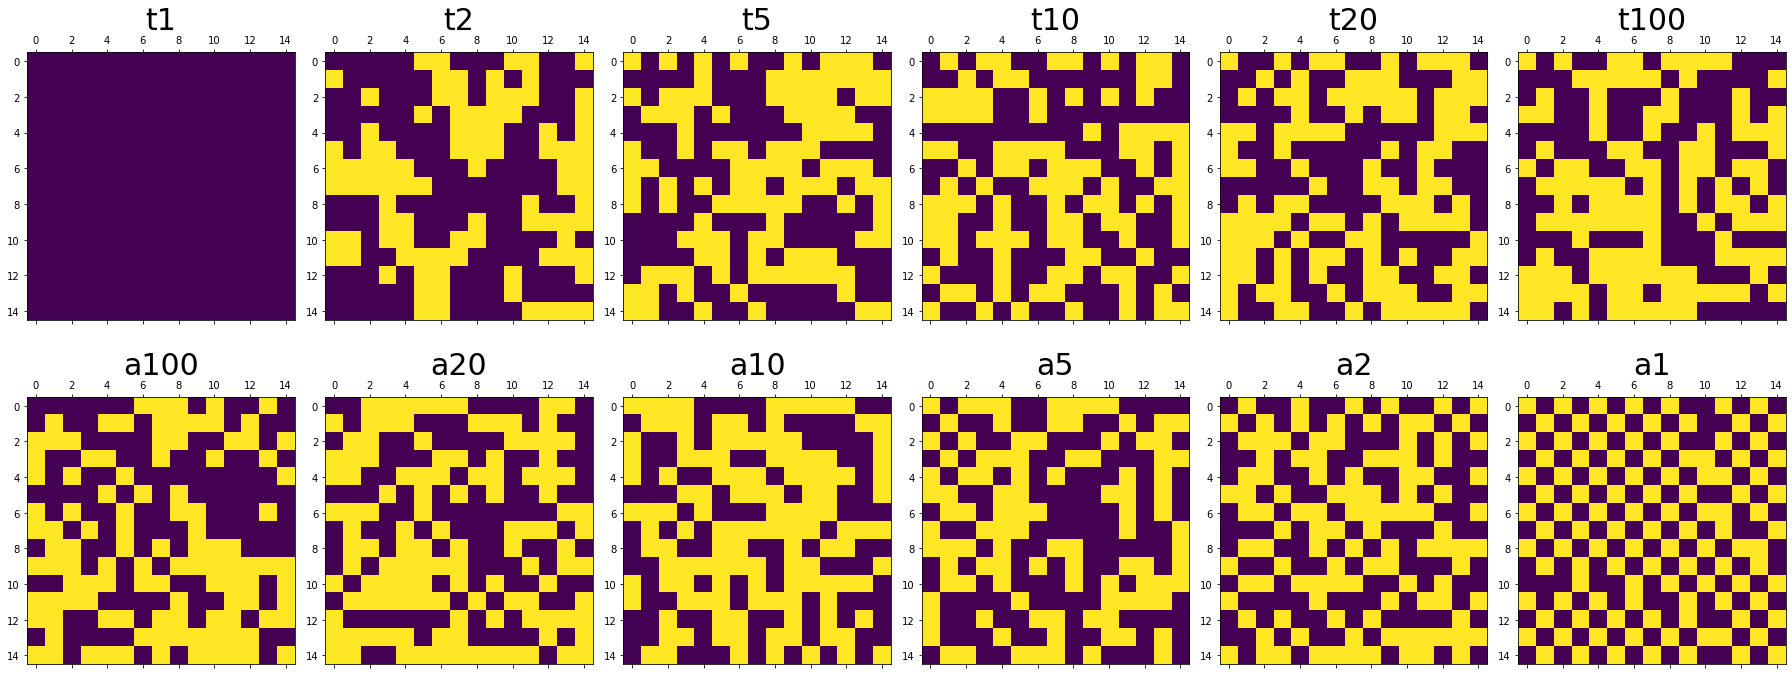

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(25,10))
axs = axs.flatten()
for i, t in enumerate(temps):
    axs[i].set_title(t, fontsize=30)
    axs[i].matshow(cfgs[t][200])

fig.tight_layout()

In [9]:
# Input image dimensions
img_rows, img_cols = cfgs['t1'][0].shape
channels = 1
img_shape = (img_rows, img_cols, channels)

# Dimensions of the embedding space
z_dim = 3

print('Input image shape: ', img_shape)
print('Feature space dimension: ', z_dim)

Input image shape:  (15, 15, 1)
Feature space dimension:  3


## 2. Representation Learning

Discriminate between different Ising systems by embedding each system into a probability space and optimizing classification in this space. Another (better) option is to maximize between-class/within-class variance ratio (as in Fisher/Linear Discriminant Analysis). This would directly optimize statistical distances.

### 2.1 Model definitions

In [14]:
def build_embedding(img_shape, nfilt, ndim):
    """Model to embed 2D Ising configurations into an ndim-dimensional probability space.
    
    Collect local configurations from 3x3 windows, convert them into n-dimensional features,
    and convert those into a probability vector using average pooling over the whole
    configuration. 
    
    Arguments
    ---------
    img_shape: tuple
        Shape of the input data
    nfilt: int
        Number of filters in the first layer
    ndim: int
        Embedding dimension
    """

    model = Sequential()
    model.add(Conv2D(nfilt, kernel_size=3, strides=2, input_shape=img_shape, padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(ndim, kernel_size=1, strides=1, padding='valid'))
    model.add(Softmax())
    model.add(Lambda(lambda x: tf.math.sqrt(x)))
    model.add(GlobalAveragePooling2D())  # Create a unit vector for the whole configuration

    return model

In [15]:
def build_classifier(nclass):
    """Model to embed 2D Ising configurations into an ndim-dimensional probability space.
    Collect local configurations from 3x3 windows, convert them into n-dimensional features,
    and convert those into a probability vector using average pooling over the whole
    configuration. 
    
    Arguments
    ---------
    nclass: int
        Number of classes
    """

    model = Sequential()
    model.add(Dense(nclass))
    model.add(Softmax())
    
    return model

In [16]:
def build_discriminator(mdl_embed, mdl_class):
 
    # Build a complete model
    model = Sequential()
    model.add(mdl_embed)
    model.add(mdl_class)
    
    return model

### 2.2 Training data preparation

In [17]:
# Set up training data
data_list = [np.expand_dims(np.array(cfgs[t][:]), axis=-1) for t in temps]#["t1", "t100", "a1"]]
data_train = np.concatenate(data_list, axis=0)
data_train.shape

(12000, 15, 15, 1)

In [18]:
# Set up labels
#data_out = np.concatenate([mm(dat) for dat in data_list], axis=0)
class_list = [np.array(len(cfg)*[i]) for i, cfg in enumerate(data_list)]
labels = np.concatenate(class_list, axis=0)
labels.shape

(12000,)

In [19]:
idx = np.random.permutation(len(labels)) # mix them a bit
data_train = data_train[idx]
labels = labels[idx]
labels_tf = tf.convert_to_tensor(labels, dtype=tf.int32)
data_train.shape, labels_tf.shape

((12000, 15, 15, 1), TensorShape([12000]))

### 2.3 Model building, compiling, and training

**Define loss function for representation learning**

In [41]:
# Categorical cross-entropy for training using a classifier
loss_type = 'classif_crossentropy'
#loss_type = 'trace'
#loss_type = 'variance'

if loss_type == 'classif_crossentropy':
    repr_loss = tf.keras.losses.SparseCategoricalCrossentropy()
elif loss_type == 'trace':
    repr_loss = trace_loss()
elif loss_type == 'variance':
    repr_loss = variance_loss()

In [48]:
# Build embedding
mdl_embed = build_embedding(img_shape, nfilt=8, ndim=3)

# Build classification layers on top of embedding to train the embedder
mdl_class = build_classifier(nclass=len(np.unique(labels)))

# Connect embedding and classification for representation learning
mdl_train = build_discriminator(mdl_embed, mdl_class)

In [49]:
mdl_train.compile(loss=repr_loss, metrics=['accuracy'], optimizer=RMSprop())
#mdl_embed.compile(loss=repr_loss, optimizer=RMSprop(epsilon=1e-4))

In [50]:
history = mdl_train.fit(data_train, labels_tf, batch_size=240, epochs=1000, verbose=1)
#history = mdl_embed.fit(data_train, labels_tf, batch_size=240, epochs=100, verbose=1)

Epoch 1/1000
50/50 [==============================] - 0s 2ms/step - loss: 2.5347 - accuracy: 0.0834
Epoch 2/1000
50/50 [==============================] - 0s 2ms/step - loss: 2.5024 - accuracy: 0.0831
Epoch 3/1000
50/50 [==============================] - 0s 1ms/step - loss: 2.4793 - accuracy: 0.0839
Epoch 4/1000
50/50 [==============================] - 0s 1ms/step - loss: 2.4651 - accuracy: 0.0931
Epoch 5/1000
50/50 [==============================] - 0s 1ms/step - loss: 2.4554 - accuracy: 0.1618
Epoch 6/1000
50/50 [==============================] - 0s 1ms/step - loss: 2.4432 - accuracy: 0.1701
Epoch 7/1000
50/50 [==============================] - 0s 2ms/step - loss: 2.4347 - accuracy: 0.1734
Epoch 8/1000
50/50 [==============================] - 0s 2ms/step - loss: 2.4268 - accuracy: 0.1668
Epoch 9/1000
50/50 [==============================] - 0s 2ms/step - loss: 2.4132 - accuracy: 0.1879
Epoch 10/1000
50/50 [==============================] - 0s 2ms/step - loss: 2.4079 - accuracy: 0.1883

50/50 [==============================] - 0s 1ms/step - loss: 1.8480 - accuracy: 0.4225
Epoch 83/1000
50/50 [==============================] - 0s 2ms/step - loss: 1.8341 - accuracy: 0.4315
Epoch 84/1000
50/50 [==============================] - 0s 2ms/step - loss: 1.8256 - accuracy: 0.4323
Epoch 85/1000
50/50 [==============================] - 0s 1ms/step - loss: 1.8303 - accuracy: 0.4334
Epoch 86/1000
50/50 [==============================] - 0s 1ms/step - loss: 1.8375 - accuracy: 0.4228
Epoch 87/1000
50/50 [==============================] - 0s 2ms/step - loss: 1.8210 - accuracy: 0.4321
Epoch 88/1000
50/50 [==============================] - 0s 2ms/step - loss: 1.8195 - accuracy: 0.4329
Epoch 89/1000
50/50 [==============================] - 0s 2ms/step - loss: 1.8097 - accuracy: 0.4330
Epoch 90/1000
50/50 [==============================] - 0s 1ms/step - loss: 1.8300 - accuracy: 0.4294
Epoch 91/1000
50/50 [==============================] - 0s 2ms/step - loss: 1.8087 - accuracy: 0.4308
Epoc

50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.4480
Epoch 163/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0841
Epoch 164/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0826
Epoch 165/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0864
Epoch 166/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0866
Epoch 167/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0854
Epoch 168/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0820
Epoch 169/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0843
Epoch 170/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0819
Epoch 171/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0867
Epoch 172/1000
50/50 [===

50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0851
Epoch 245/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0857
Epoch 246/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0838
Epoch 247/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0831
Epoch 248/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0836
Epoch 249/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0763
Epoch 250/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0820
Epoch 251/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0807
Epoch 252/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0862
Epoch 253/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0837
Epoch 254/1000
50/50 [===

50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0802
Epoch 327/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0847
Epoch 328/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0816A: 0s - loss: nan - accuracy: 0.081
Epoch 329/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0881
Epoch 330/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0809
Epoch 331/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0850
Epoch 332/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0820
Epoch 333/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0867
Epoch 334/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0858
Epoch 335/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accurac

50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0852
Epoch 409/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0814
Epoch 410/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0871
Epoch 411/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0867
Epoch 412/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0853A: 0s - loss: nan - accuracy: 0.086
Epoch 413/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0815
Epoch 414/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0857
Epoch 415/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0856
Epoch 416/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0832
Epoch 417/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accurac

50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0817
Epoch 491/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0856
Epoch 492/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0866
Epoch 493/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0829
Epoch 494/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0842
Epoch 495/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0839
Epoch 496/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0797
Epoch 497/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0812
Epoch 498/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0841
Epoch 499/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0848
Epoch 500/1000
50/50 [===

50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0833
Epoch 573/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0873
Epoch 574/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0803
Epoch 575/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0836
Epoch 576/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0835
Epoch 577/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0834
Epoch 578/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0851
Epoch 579/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0835
Epoch 580/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0847
Epoch 581/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0840
Epoch 582/1000
50/50 [===

50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0842
Epoch 655/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0864
Epoch 656/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0792
Epoch 657/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0824
Epoch 658/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0843
Epoch 659/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0810
Epoch 660/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0813
Epoch 661/1000
50/50 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0803
Epoch 662/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0830
Epoch 663/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0849
Epoch 664/1000
50/50 [===

50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0809
Epoch 737/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0830
Epoch 738/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0828
Epoch 739/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0808
Epoch 740/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0830
Epoch 741/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0834
Epoch 742/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0817
Epoch 743/1000
50/50 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0808
Epoch 744/1000
50/50 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0883
Epoch 745/1000
50/50 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0848
Epoch 746/1000
50/50 [===

50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0796
Epoch 819/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0832
Epoch 820/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0820
Epoch 821/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0830
Epoch 822/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0870
Epoch 823/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0867
Epoch 824/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0840
Epoch 825/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0818
Epoch 826/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0821
Epoch 827/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0885
Epoch 828/1000
50/50 [===

50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0841
Epoch 901/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0816
Epoch 902/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0816
Epoch 903/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0858
Epoch 904/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0819
Epoch 905/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0841
Epoch 906/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0830
Epoch 907/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0840
Epoch 908/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0830
Epoch 909/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0799
Epoch 910/1000
50/50 [===

50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0835
Epoch 983/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0848
Epoch 984/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0835
Epoch 985/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0817
Epoch 986/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0826
Epoch 987/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0837
Epoch 988/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0849
Epoch 989/1000
50/50 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0841
Epoch 990/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0866
Epoch 991/1000
50/50 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.0850
Epoch 992/1000
50/50 [===

### 2.4 Model performance

Text(0.5, 0.98, 'Optimization History')

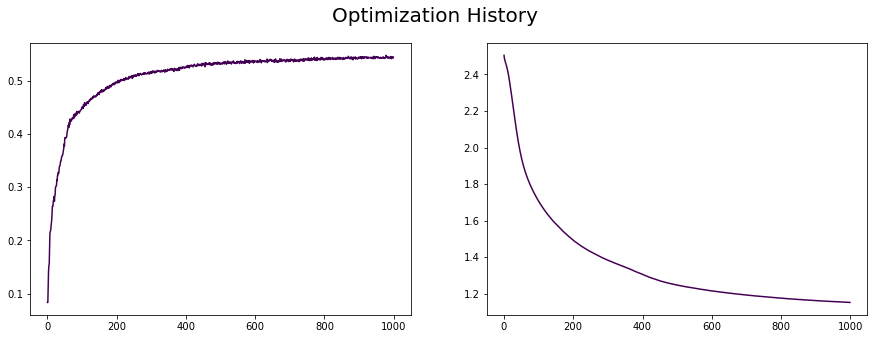

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history.history['accuracy'])
axs[1].plot(history.history['loss'])
fig.suptitle("Optimization History", fontsize=20)

In [46]:
# Set up training data and lables
data_out = np.concatenate([mdl_embed(dat) for dat in data_list], axis=0)
class_list = [np.array(len(cfg)*[i]) for i, cfg in enumerate(data_list)]
labels_out = np.concatenate(class_list, axis=0)
data_out.shape, labels_out.shape

((12000, 3), (12000,))

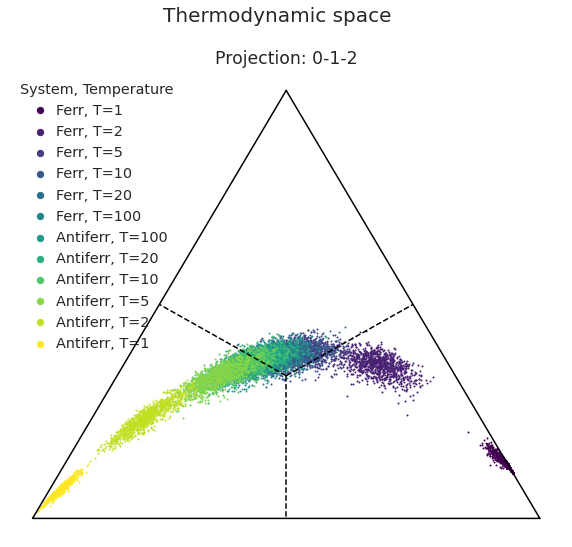

In [47]:
trslt = {'t':'Ferr', 'a':"Antiferr"}
cnames = [f'{trslt[t[0]]}, T={t[1:]}' for t in temps]
plot_ternary(data_out[idx], labels_out[idx], np.unique(labels_out), class_names = cnames, plt_title = "Thermodynamic space",
             size=10)

## 3. Learning and Predicting System Properties

Learn mapping between the trained embedding (thermodynamic) space and physical properties

### 3.1 System temperature

#### 3.1.1 Model and its training

In [28]:
def build_temp_layers(nunit):
    """Determine temperature of the system generating given configurations.
    
    Note that the effect of temperature is indistinguishable from the overall interaction strength.
    
    Arguments:
    ----------
    ndim: int
        dimension of the input embedding space 
        
    Returns:
    --------
    model: tensorflow model
        Model translating a vector in the thermodynamic space into temperature.
    """
    model = Sequential()
    model.add(Lambda(lambda x: tf.math.log(x)))
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Lambda(lambda x: tf.math.exp(x)))
    
    return model

In [29]:
def build_property_learn(mdl_embed, mdl_prop):
 
    mdl_embed.trainable = False

    # Build a complete model
    model = Sequential()
    model.add(mdl_embed)
    model.add(mdl_prop)

    return model

In [30]:
mdl_temp_layers = build_temp_layers(6)
mdl_temp = build_property_learn(mdl_embed, mdl_temp_layers)

In [31]:
mdl_temp.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['MAE'], optimizer=Adam())

In [32]:
temp_list = [np.array(len(cfg)*[1/float(t[1:])]) for t, cfg in zip(temps, data_list)]
y_temp = np.concatenate(temp_list, axis=0)
y_temp.shape
y_temp = y_temp[idx]

In [33]:
history = mdl_temp.fit(data_train, y_temp, epochs=100, verbose=1)

Epoch 1/100
375/375 [==============================] - 1s 1ms/step - loss: 537.8667 - MAE: 4.9006
Epoch 2/100
375/375 [==============================] - 0s 1ms/step - loss: 25.2007 - MAE: 1.7924
Epoch 3/100
375/375 [==============================] - 0s 1ms/step - loss: 8.8874 - MAE: 1.2257
Epoch 4/100
375/375 [==============================] - 0s 1ms/step - loss: 4.4129 - MAE: 0.9997
Epoch 5/100
375/375 [==============================] - 0s 1ms/step - loss: 2.4915 - MAE: 0.8326
Epoch 6/100
375/375 [==============================] - 0s 1ms/step - loss: 1.5775 - MAE: 0.7277
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 1.1003 - MAE: 0.6462
Epoch 8/100
375/375 [==============================] - 1s 2ms/step - loss: 0.7500 - MAE: 0.5680
Epoch 9/100
375/375 [==============================] - 1s 2ms/step - loss: 0.5875 - MAE: 0.5186
Epoch 10/100
375/375 [==============================] - 0s 1ms/step - loss: 0.4044 - MAE: 0.4598
Epoch 11/100
375/375 [==============

375/375 [==============================] - 1s 2ms/step - loss: 0.0046 - MAE: 0.0517
Epoch 86/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0045 - MAE: 0.0508
Epoch 87/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0046 - MAE: 0.0518
Epoch 88/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0044 - MAE: 0.0516
Epoch 89/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0044 - MAE: 0.0511
Epoch 90/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0046 - MAE: 0.0514
Epoch 91/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0043 - MAE: 0.0502
Epoch 92/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0044 - MAE: 0.0514
Epoch 93/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0045 - MAE: 0.0518
Epoch 94/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0044 - MAE: 0.0511
Epoch 95/100
375/375 [=====================

#### 3.1.2 Evaluation and predictions

In [34]:
y_pred = mdl_temp.predict(data_train)

Text(0.5, 1.0, 'Histograms of inverse temperatures: simulations vs. predictions')

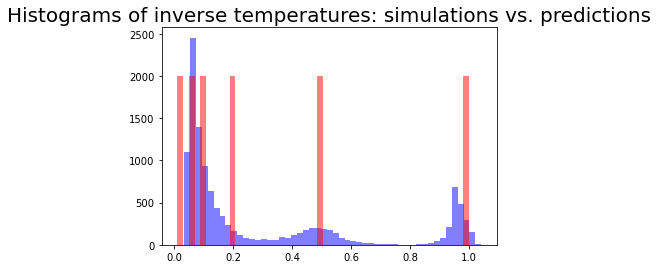

In [35]:
_ = plt.hist(np.ravel(y_pred), color='b', alpha=0.5, bins=50, label="Predicted")
_ = plt.hist(np.ravel(y_temp), color='r', alpha=0.5, bins=50, label="Simulated")
plt.title("Histograms of inverse temperatures: simulations vs. predictions", fontsize=20)

Text(0.5, 1.0, 'Predicted vs. simulated inverse temperature')

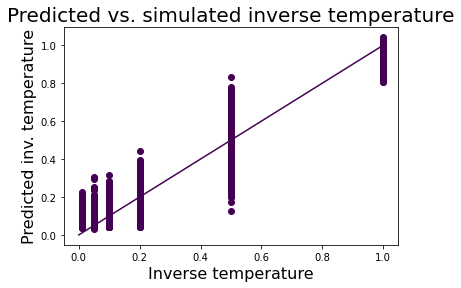

In [36]:
plt.scatter(np.ravel(y_temp), np.ravel(y_pred))
plt.plot([0, 1], [0, 1])
plt.xlabel("Inverse temperature", fontsize=16)
plt.ylabel("Predicted inv. temperature", fontsize=16)
plt.title("Predicted vs. simulated inverse temperature", fontsize=20)

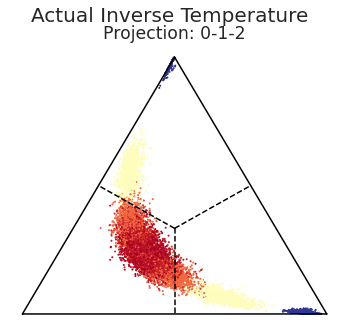

In [37]:
plot_ternary_continuum(data_out[idx], np.ravel(y_temp), size=6, plt_title = "Actual Inverse Temperature")

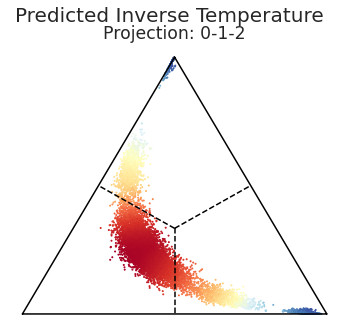

In [38]:
plot_ternary_continuum(data_out[idx], np.ravel(y_pred), size=6, plt_title = "Predicted Inverse Temperature")

### 3.2 System type: Ferromagnetic vs. Antiferromagnetic

#### 3.2.1 Model and its training

In [39]:
def build_system_id_layers(ndim):
    """Classify configurations as coming from ferromagnetic or antiferromagnetic systems
        
    Note that the effect of temperature is indistinguishable from the overall interaction strength.
    
    Arguments:
    ----------
    ndim: int
        dimension of the input embedding space 
        
    Returns:
    --------
    model: tensorflow model
        Model translating a vector in the thermodynamic space into temperature.
    """
       
    model = Sequential()
    model.add(Lambda(lambda x: tf.math.log(x)))
    model.add(Dense(ndim))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [40]:
mdl_sysid_layers = build_system_id_layers(ndim = 4)
mdl_sysid = build_property_learn(mdl_embed, mdl_sysid_layers)

In [41]:
mdl_sysid.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=Adam())

In [42]:
sysid_list = [np.array(len(cfg)*[int(t[0] == "a")]) for t, cfg in zip(temps, data_list)]
y_sysid = np.concatenate(sysid_list, axis=0)
y_sysid = np.expand_dims(y_sysid, axis=-1)
y_sysid.shape
y_sysid = y_sysid[idx]

In [43]:
history = mdl_sysid.fit(data_train, y_sysid, epochs=100, verbose=1)

Epoch 1/100
375/375 [==============================] - 1s 1ms/step - loss: 0.5963 - accuracy: 0.6720
Epoch 2/100
375/375 [==============================] - 1s 2ms/step - loss: 0.4612 - accuracy: 0.8321
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3927 - accuracy: 0.8471
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3524 - accuracy: 0.8502
Epoch 5/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3311 - accuracy: 0.8484
Epoch 6/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3156 - accuracy: 0.8496
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3067 - accuracy: 0.8518
Epoch 8/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3077 - accuracy: 0.8498
Epoch 9/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3066 - accuracy: 0.8507
Epoch 10/100
375/375 [==============================] - 1s 2ms/step - loss: 0.2971 - accura

375/375 [==============================] - 1s 2ms/step - loss: 0.2917 - accuracy: 0.8566
Epoch 82/100
375/375 [==============================] - 1s 2ms/step - loss: 0.2958 - accuracy: 0.8518
Epoch 83/100
375/375 [==============================] - 1s 2ms/step - loss: 0.2991 - accuracy: 0.8498
Epoch 84/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3028 - accuracy: 0.8524
Epoch 85/100
375/375 [==============================] - 1s 2ms/step - loss: 0.2896 - accuracy: 0.8606
Epoch 86/100
375/375 [==============================] - 1s 2ms/step - loss: 0.2959 - accuracy: 0.8561
Epoch 87/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3062 - accuracy: 0.8485
Epoch 88/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3083 - accuracy: 0.8478
Epoch 89/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3065 - accuracy: 0.8487
Epoch 90/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3029 - accuracy: 

#### 3.2.2 Evaluation and predictions

In [44]:
# Predict categories: ferromagnetic vs. non-ferromagnetic
y_pred = (np.ravel(mdl_sysid.predict(data_train)) > 0.5).astype(np.int)

idx.shape
print("Confusion matrix")
confusion_matrix(np.ravel(y_sysid), np.ravel(y_pred))

Confusion matrix


array([[5104,  896],
       [ 893, 5107]])

In [45]:
#idx = np.random.permutation(len(correct))  # mix them a bit
correct = (np.ravel(y_sysid) != np.ravel(y_pred)).astype(np.int)

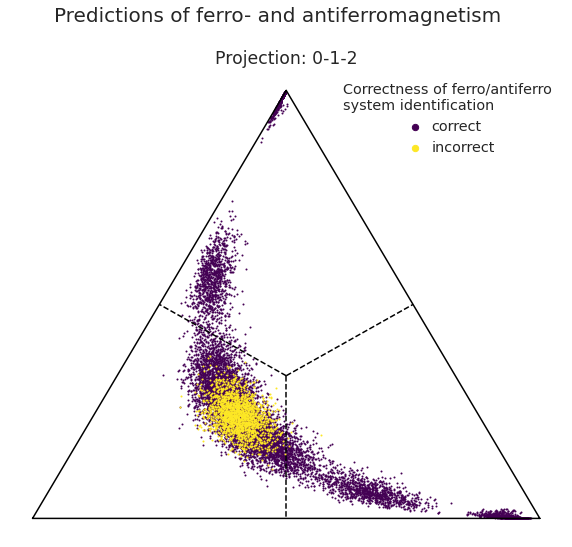

In [46]:
#idx = np.random.permutation(len(correct))  # mix them a bit
plot_ternary(data_out[idx], correct, np.unique(correct), class_names = ["correct", "incorrect"],
             size=10, plt_title = "Predictions of ferro- and antiferromagnetism",
             legend_title = "Correctness of ferro/antiferro\nsystem identification")

## 4. Visualize filters and activations